# Relaxando Com CouchDB
### Objetivo: ensinar como utilizar o couchDB, além de detalhar seus usos e aplicações

## Parte 1
### Para que serve o couchDB?

CouchDB é uma aplicação que visa simplicidade. Com ele, é possível criar banco de dados não-relacionais no formato JSON, acessar os documentos via HTTP por meio de sua API RESTful e modificá-los com JavaScript. Além disso, ele é compatível com aplicativos web e mobile.

Há 4 motivos básicos pelo qual o CouchDB é tão fácil para o usuário:

1. Ele é feito para que mesmo uma pessoa com pouco conhcimento técnico possa manusear. A aplicação possui um console web de administração (Fauxton) para facilitar ainda mais seu uso. Dessa forma não é necessário escrever nenhuma linha de código para montar um banco de dados.

2. Ele possui uma arquitetura interna tolerante a erros e, se ocorrer uma falha, ele as contém de forma a não afetar todo o sistema.

3. Ele lida bem com mudanças drásticas no tráfego de uma aplicação. Mesmo que as requisições fiquem mais lentas, todas serão respondidas.

4. Ele possui features para garantir a escalabilidade do hardware.

A principal funcionalidade do CouchDB é a replicação entre bancos de dados locais ou remotos.

O teorema CAP afirma que é impossível forneçer simultaneamente as 3 principais garantias de um sistema distribuído (consistência, disponibilidade e tolerância a partições), sendo 2 o máximo possível. A principal diferença entre o CouchDB e outros sistemas desse tipo como [RDBMS](https://en.wikipedia.org/wiki/Relational_database#RDBMS) e [Paxos](https://en.wikipedia.org/wiki/Paxos_%28computer_science%29) é que ele aceita consistência eventual ao invés de colocar isso como principal prioridade, como mostra a imagem a baixo:

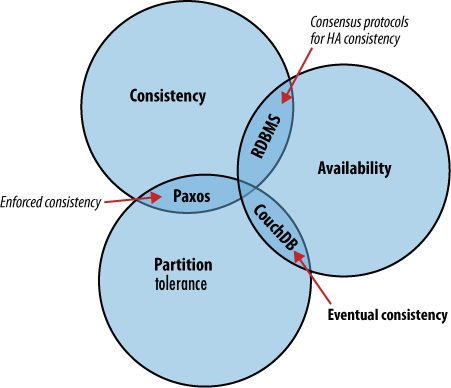

Sendo a garantia de partições tolerantes a falhas necessária para a replicação entre bancos de dados, a escolha por disponibilidade ao invés de consistência implica em aumento de performance. Isso se dá pois, priorizar a consistência faz com que cada alteração no banco de dados torne ele indisponível até que a alteração esteja completa, para que todos possuam a mesma versão do mesmo. Garantir disponibilidade torna possível a realização de processos em paralelo e, apesar da geração de conflitos que isso causa, há um aumento significativo de performance que é especialmente importante se o sistema visa escalabilidade.

O CouchDB possui um sistema de revisões para ajudar com conflitos que será explicado na parte 4

## Parte 2
### Instalação

Abra o link abaixo e siga os passos para instalar o CouchDB:

[Link de instalação](http://docs.couchdb.org/en/stable/install/index.html)

## Parte 3
### Set-up e criação de um banco de dados

Após a instalação entre no Fauxton no endereço: http://127.0.0.1:5984/_utils/#/setup

A seguinte tela deverá aparecer:

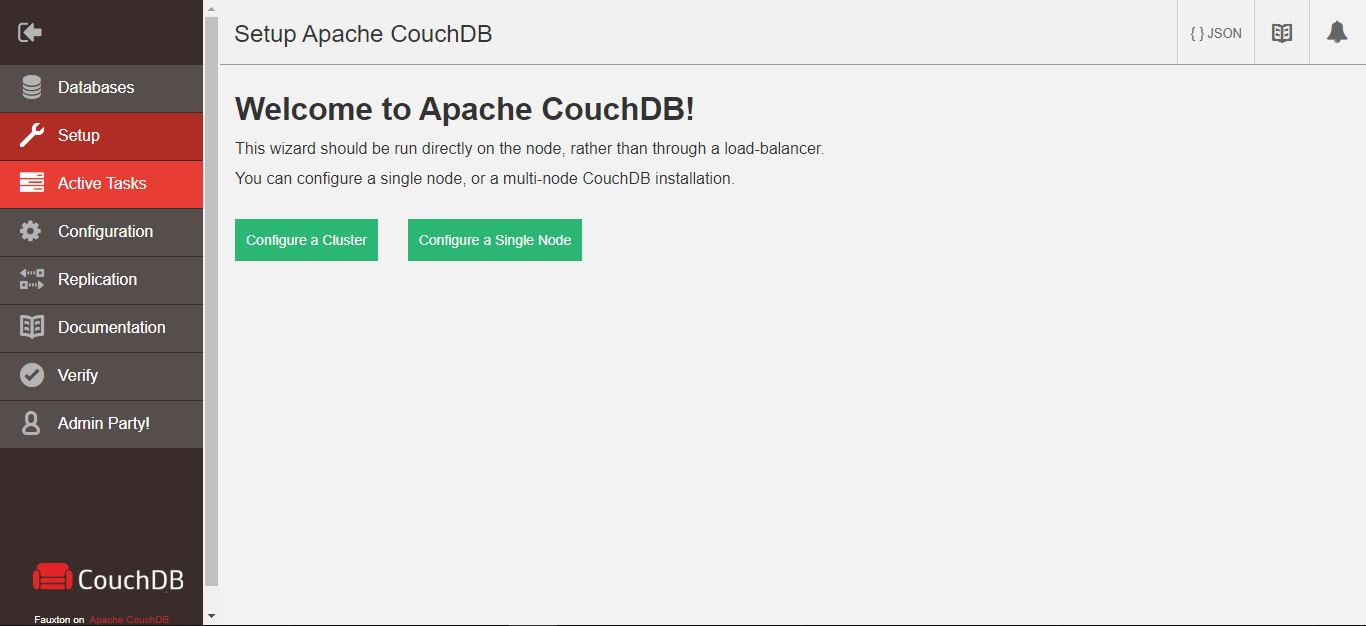

Para realizar uma aplicação real, o mais seguro seria montar um Cluster, pois há a garantia de que nodes podem cair sem afetar o sistema. Porém, por motivos didáticos iremos montar apenas um node.

Aperte o botão "Configure a Single Node" e crie suas credenciais.

Coloque como endereço o localhost (127.0.0.1) e mantenha a porta 5984.
***
Há duas formas de criar um banco de dados, pelo Fauxton ou por requests. Começaremos pelo primeiro:

Dentro da aba "Databases" clique em "Create Database" na parte superior da tela e insira o nome "albums" para sua base de dados. Para criar um documento basta clicar no botão "Create Document" e adicionar dados no formato de um arquivo JSON tomando cuidado para não deletar "_id".

Se quiser deletar uma base de dados é só clicar no símbolo de lixo ao lado de seu nome. Não delete "albums", ele será usado futuramente.
***
Agora, vamos criar uma base de dados usando requests:

In [ ]:
import requests
import os
import json

Insira abaixo o seu usuário e senha do CouchDB:

In [ ]:
username = 'INSIRA SEU USUARIO'
senha = 'INSIRA SUA SENHA'
ip = '127.0.0.1'
porta = '5984'

O comando abaixo lista todos os DBs, ele é um 'GET' no formato:

>'http://< endereco couchdb>:< porta couchdb>/_all_dbs'

In [ ]:
res = requests.get('http://%s:%s/_all_dbs' % (ip, porta))
res.json()

As três primeiras são bases de dados padrão do CouchDB, porém repare na última: "albums", a base de dados que nós criamos pelo Fauxton.

O comando abaixo adiciona a base de dados "baseball", ele é um 'PUT' no formato:

> 'http://< endereco couchdb>:< porta couchdb>/< nome DB>'

In [ ]:
res = requests.put('http://%s:%s@%s:%s/baseball' % (username,senha,ip, porta))
res.json()

O CouchDB deverá retornar "ok".

Verificamos que, ao coletar de novo os DBs, temos a adição de "baseball":

In [ ]:
res = requests.get('http://%s:%s/_all_dbs' % (ip, porta))
res.json()

Se tentarmos adicionar uma base com o mesmo nome, ele não permite:

In [ ]:
res = requests.put('http://%s:%s@%s:%s/baseball' % (username,senha,ip, porta))
res.json()

O comando abaixo deleta a base de dados "baseball", ele é um 'DELETE' no formato:

> 'http://< endereco couchdb>:< porta couchdb>/< nome DB>'

In [ ]:
res = requests.delete('http://%s:%s@%s:%s/baseball' % (username,senha,ip, porta))
res.json()

Verificamos que ele não aparece mais na lista de DBs:

In [ ]:
res = requests.get('http://%s:%s/_all_dbs' % (ip, porta))
res.json()

## Parte 4
### Popular o seu banco de dados

Apos criado o DB, devemos saber como trabalhar com os dados dele. A forma utilizada para guardar esses dados não relacionais são os documentos, que são escritos em formato json. Para organizar os dados, cada documneto tem um id próprio, que pode ser qualquer coisa, mas é recomendado utilizar o [UUID](https://pt.wikipedia.org/wiki/Identificador_%C3%BAnico_universal), que inclusive pode ser gerado pela API do próprio couchdb.

Para criar um novo documento para popular o banco de dados, vamos primeiro gerar um id para o documento. Faremos isso enviando uma chamada 'GET' no formato a seguir:       
> 'http://< endereco couchdb>:< porta couchdb>/_uuids'

In [ ]:
# Criar DB albums, caso não exista
res = requests.put('http://%s:%s@%s:%s/albums' % (username,senha,ip, porta))
print(res.json())


# Endereço para gerar o ID 
res = requests.get('http://%s:%s/_uuids' % (ip, porta))
res.json()

# Salvando o ID gerado
uuid = res.json()['uuids'][0]
uuid

Agora que geramos e salvamos o ID para nosso novo documento, vamos gerar o documento e adicionar ao banco de dados "albums". Para isso vamos colocar em json os dados. Vamos salvar nomes de pessoas e que instrumentos elas tocam no formato a seguir:

> {
"Key1" : "Valor1",
"Key2" : "Valor2",
"Key3" : "Valor3",
...
}

E enviamos esses dados no *body* da requisição, com o formato a seguir usando **' PUT '** :

> 'http://< usuario >:< senha >@< endereco couchdb>:< porta couchdb>/< nome DB>/< id do documento >'


In [ ]:
# Vamos colocar no banco os dados
dados_a_serem_salvos = '{"Nome":"Carlos","Instrumento":"Guitarra"}'

res = requests.put('http://%s:%s@%s:%s/albums/%s' % (username, senha, ip, porta, uuid), data=dados_a_serem_salvos)
print(res.json())

Vamos colocar mais alguns dados, para popular o banco:

In [ ]:
dados_a_serem_salvos = ['{"Nome":"Pedro","Instrumento":"Guitarra"}','{"Nome":"Magda","Instrumento":"Piano"}','{"Nome":"Jubileu","Instrumento":"Saxofone"}']

for i in dados_a_serem_salvos:
    
    res = requests.get('http://%s:%s/_uuids' % (ip,porta))
    # Salvando o ID gerado
    uuid = res.json()['uuids'][0]
    # Salvando dados
    res = requests.put('http://%s:%s@%s:%s/albums/%s' % (username,senha,ip,porta,uuid),data=i)
    print(res.json())

Para ver os ids de todos os documentos de um DB podemos utilizar a requisição no formato

> 'http://< endereco couchdb>:< porta couchdb >/< nome DB >/_all_docs'

In [ ]:
res = requests.get('http://%s:%s/albums/_all_docs' % (ip,porta))
res.json()

Vamos fazer uma consulta em um documento específico, para isso basta fazer uma requisição GET no formato : 

> 'http://< endereco couchdb>:< porta couchdb >/< nome DB >/< id do documento >'

In [ ]:
res = requests.get('http://%s:%s/albums/%s' % (ip, porta, uuid))
res.json()

Para editar um documento, devemos fazer uma revisão do mesmo. Ao fazer uma revisão, carregamos o arquivo insteiro e então alteramos a parte nescessária, e então identificamos tambem o id de revisão, que é um valor chamado '*rev*', o qual deve ser enviado para evitar que no meio tempo que o doc foi carregado e alterado, outra pessoa tenha alterado já antes e estejamos sobrescrevendo algo importante. Na parte 1 explicamos o motivo pelo qual isso é necessário, o fator de consistência eventual do CouchDB.

O valor '*rev*' vem junto do documento quando carregado, e ele é alterado a cada revisão feita.
Vamos revisar o documento que puxamos no exemplo acima.

In [ ]:
rev = res.json()['_rev']

nova_alteracao = '{"Nome":"Jose","Instrumento":"Saxofone", "_rev":"%s"}' % (rev) 


res1 = requests.put('http://%s:%s@%s:%s/albums/%s' % (username,senha,ip,porta,uuid), data=nova_alteracao)

res1.json()

In [ ]:
res = requests.get('http://%s:%s/albums/%s' % (ip, porta, uuid))
res.json()

Uma vez que a revisão é feita o sistema gera um novo valor para rev e o retorna para o usuário. Agora podemos tambem apagar lógicamente um documento. Nese caso o formato do requisição "**DELETE**" é:

> 'http://< usuario >:< senha >@< endereco couchdb>:< porta couchdb >/< nome DB >/< id do documento >?rev=< valor rev do documento >'

Vamos testar isso apagando o arquivo que acabamos de alterar. 

In [ ]:
rev = res1.json()['rev']
json_delete = '{"_rev":"%s"}' % (rev)
res1 = requests.delete('http://%s:%s@%s:%s/albums/%s?rev=%s' % (username,senha,ip,porta,uuid,rev))
res1.json()

Assim podemos ver que se fizermos a requisição para ver o documento o resultado retorna que os dados não foram encontrados pois foram apagados.

In [ ]:
res = requests.get('http://%s:%s/albums/%s' % (ip,porta,uuid))
res.json()

## Parte 5
### Map Reduce

O mapreduce são mapas e funções reduces predefinidas e programadas em javascript, que serverm para selecionar os dados requeridos dos documentos sem se preocupar com a formatação de cada documento, facilitando a busca quando o DB for bastante variado. 

Para criar uma view, que é como se chamam essas funções do couchdb, é preciso criar um documento que irá conter todos os views criados. O formato do requerimento **' PUT '** é:

> 'http://< usuario >:< senha >@< endereco couchdb>:< porta couchdb >/< nome DB >/_design/< nome do documento de views >'

E a função é enviada em um json com o seguinte formato:

> {"views": {"< Nome da View >": {"map": "< Função javascript do view >"}},"language": "javascript"}

No caso atual, vamos criar uma view para puxar os nomes de todos os docs.

> *function(doc) {emit(doc.Nome);}*

A função em javascript recebe em *doc* todos os dados de cada documento, e a função *emit* é utilizada para enviar os dados quando ocorre a requisição 


In [ ]:
jj = {"views": {"new-view": {"map": "function(doc) {\n  var key;\n  var instrumentos = {};\n  \n    emit(0,doc.Nome)\n  \n \n}"}},"language": "javascript"}


res = requests.put('http://%s:%s@%s:%s/albums/_design/doc_view' % (username,senha,ip,porta),data=json.dumps(jj))
print(res.json())

Para ver o resultado do view, é so fazer uma requisição **' GET '** com o formato a seguir:

> 'http://< endereco couchdb>:< porta couchdb >/< nome DB >/_design/< nome do documento de views >/view/< Nome do view >'

In [ ]:
res = requests.get('http://%s:%s@%s:%s/albums/_design/doc_view/_view/new-view' % (username,senha,ip,porta))
res.json()

## Parte 6
### Replicação local

Replicação é criar uma cópia do DB que pode ser sincronizado constantemente. Inicialmente faremos uma replicação local para demonstração. O formato da requisição é:

> 'http://< usuario >:< senha >@< endereco couchdb>:< porta couchdb >/_replicate'

E o formato dos dados a serem enviados juntos é:


> {"source": "< endereco do DB a ser replicado >",

> "target": "< endereço a receber os dados >", 

> "create_target": < booleano para definir se precisa criar o DB target >, 

> "continuous": < booleano para definir se a replicação manterá os DBs sincronizados >} ' 


In [ ]:
url1 = "http://%s:%s@%s:%s/teste01" % (username,senha,ip,porta)
url2 = "http://%s:%s@%s:%s/albums" % (username,senha,ip,porta)

json_data = json.dumps({"source": url2, "target": url1, "create_target": True, "continuous": True})
headers = {'content-type': 'application/json'}

res = requests.post("http://%s:%s@%s:%s/_replicate" % (username,senha,ip,porta),data = json_data,headers=headers)
res.json()

A replicação acima so funciona em uma diração, fazendo com que o novo DB que criamos seja somente para backup. Para fazer com que os DBs estejam totalmente sincronizados seria preciso criar mais uma ação de replicação para fazer o caminho inverso. 

In [ ]:
url1 = "http://%s:%s@%s:%s/teste01" % (username,senha,ip,porta)
url2 = "http://%s:%s@%s:%s/albums" % (username,senha,ip,porta)

json_data = json.dumps({"source": url1, "target": url2, "create_target": False, "continuous": True})
headers = {'content-type': 'application/json'}

res = requests.post("http://%s:%s@%s:%s/_replicate" % (username,senha,ip,porta),data = json_data,headers=headers)
res.json()

Agora para testar a replicação, vamos colocar um documento novo no DB original, e então verificar a replicação no outro.

In [ ]:
i = '{"Nome":"Jake","Instrumento":"Gaita"}'

res = requests.get('http://%s:%s/_uuids' % (ip,porta))
# Salvando o ID gerado
uuid = res.json()['uuids'][0]
# Salvando dados
res = requests.put('http://%s:%s@%s:%s/albums/%s' % (username,senha,ip,porta,uuid), data=i)
print(res.json())

Agora vamos testar verificar se foi adicionado nos DBs

In [ ]:
# DB original
res = requests.get('http://%s:%s@%s:%s/albums/_design/doc_view/_view/new-view' % (username,senha,ip,porta))
res.json()

In [ ]:
# DB replicado
res = requests.get('http://%s:%s@%s:%s/teste01/_design/doc_view/_view/new-view' % (username,senha,ip,porta))
res.json()

Agora vamos colocar um novo doc no outro DB

In [ ]:
i = '{"Nome":"Terry","Instrumento":"Flauta"}'

res = requests.get('http://%s:%s/_uuids' % (ip,porta))
# Salvando o ID gerado
uuid = res.json()['uuids'][0]
# Salvando dados
res = requests.put('http://%s:%s@%s:%s/teste01/%s' % (username,senha,ip,porta,uuid),data=i)
print(res.json())

In [ ]:
# DB original
res = requests.get('http://%s:%s@%s:%s/albums/_design/doc_view/_view/new-view' % (username,senha,ip,porta))
res.json()

In [ ]:
# DB replicado
res = requests.get('http://%s:%s@%s:%s/teste01/_design/doc_view/_view/new-view' % (username,senha,ip,porta))
res.json()